## 手游玩家付费预测
### 目的：
    预测玩家45天内充值金额
### 思路
    1. 根据训练数据给出了玩家7天内充值金额和45天内充值金额，将预测分为两个部分
    2. 第一部分（二分类预测）：预测前7天有充值玩家第7天到第45天有充值为1，无充值为0
    3. 第二部分（回归预测）：预测第7天到第45天有充值的玩家充值的金额
    4. 默认前7天无充值玩家，45天内也不会充值，因为根据之前EDA显示，前7天无充值玩家，之后会充值的仅仅占千分之二
    4.合并二分类预测与回归预测结果，得出最终结果

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.rcParams['font.sans-serif']=['simHei']
import warnings
warnings.filterwarnings('ignore')

In [48]:
data =  pd.read_table('E:/数据分析学习资料汇总/游戏玩家付费金额预测/tap4fun游戏玩家付费金额预测大赛/tap4fun竞赛数据/tap_fun_train.csv',\
              sep=',')

In [84]:
data.register_time = pd.to_datetime(data.register_time).dt.normalize()
pd.set_option('display.max_columns', None)
data['price_diff'] = data.prediction_pay_price - data.pay_price

## 特征提取与处理
- 提取样本数据
- 特征分析和提取，样本平衡性,时间字段处理（pd.get_dummies）
- 定义标签集和特征集 （转化为二分类任务），归一化特征集
- 按8:2 切分为 train 和 test
- 使用交叉验证 分别用RF，KNN，SVM，LR来训练train特征集并预测结果
- 将预测结果与train标签集对比，用 accuracy，precision，recall，F score，ROC曲线评估结果
- 选择最优模型进行调参（GridSearch）

总样本数据规模： (41439, 111)


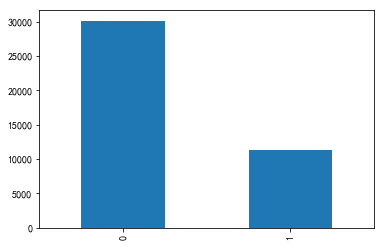

In [85]:
# 样本数据为前7天付费用户
df = data[data.pay_price>0]
print('总样本数据规模：', df.shape)
# 定义label字段，后45天无付费用户为0，后45天付费为1
df['label'] = -1
df['label'][df.price_diff==0] = 0
df['label'][df.price_diff>0] = 1
df.label.value_counts().plot.bar()

In [86]:
# 删掉user_id，price_diff，user_label
df.drop(columns=['user_id','price_diff','user_label'],inplace=True)
df.head()

,register_time,wood_add_value,wood_reduce_value,stone_add_value,stone_reduce_value,ivory_add_value,ivory_reduce_value,meat_add_value,meat_reduce_value,magic_add_value,magic_reduce_value,infantry_add_value,infantry_reduce_value,cavalry_add_value,cavalry_reduce_value,shaman_add_value,shaman_reduce_value,wound_infantry_add_value,wound_infantry_reduce_value,wound_cavalry_add_value,wound_cavalry_reduce_value,wound_shaman_add_value,wound_shaman_reduce_value,general_acceleration_add_value,general_acceleration_reduce_value,building_acceleration_add_value,building_acceleration_reduce_value,reaserch_acceleration_add_value,reaserch_acceleration_reduce_value,training_acceleration_add_value,training_acceleration_reduce_value,treatment_acceleraion_add_value,treatment_acceleration_reduce_value,bd_training_hut_level,bd_healing_lodge_level,bd_stronghold_level,bd_outpost_portal_level,bd_barrack_level,bd_healing_spring_level,bd_dolmen_level,bd_guest_cavern_level,bd_warehouse_level,bd_watchtower_level,bd_magic_coin_tree_level,bd_hall_of_war_level,bd_market_level,bd_hero_gacha_level,bd_hero_strengthen_level,bd_hero_pve_level,sr_scout_level,sr_training_speed_level,sr_infantry_tier_2_level,sr_cavalry_tier_2_level,sr_shaman_tier_2_level,sr_infantry_atk_level,sr_cavalry_atk_level,sr_shaman_atk_level,sr_infantry_tier_3_level,sr_cavalry_tier_3_level,sr_shaman_tier_3_level,sr_troop_defense_level,sr_infantry_def_level,sr_cavalry_def_level,sr_shaman_def_level,sr_infantry_hp_level,sr_cavalry_hp_level,sr_shaman_hp_level,sr_infantry_tier_4_level,sr_cavalry_tier_4_level,sr_shaman_tier_4_level,sr_troop_attack_level,sr_construction_speed_level,sr_hide_storage_level,sr_troop_consumption_level,sr_rss_a_prod_levell,sr_rss_b_prod_level,sr_rss_c_prod_level,sr_rss_d_prod_level,sr_rss_a_gather_level,sr_rss_b_gather_level,sr_rss_c_gather_level,sr_rss_d_gather_level,sr_troop_load_level,sr_rss_e_gather_level,sr_rss_e_prod_level,sr_outpost_durability_level,sr_outpost_tier_2_level,sr_healing_space_level,sr_gathering_hunter_buff_level,sr_healing_speed_level,sr_outpost_tier_3_level,sr_alliance_march_speed_level,sr_pvp_march_speed_level,sr_gathering_march_speed_level,sr_outpost_tier_4_level,sr_guest_troop_capacity_level,sr_march_size_level,sr_rss_help_bonus_level,pvp_battle_count,pvp_lanch_count,pvp_win_count,pve_battle_count,pve_lanch_count,pve_win_count,avg_online_minutes,pay_price,pay_count,prediction_pay_price,label
25,2018-01-26,30000.0,97200.0,20000.0,0.0,0.0,0.0,160500.0,80392.0,12000.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,260,0,75,0,0,0,165,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44.666667,0.99,1,0.99,0
40,2018-01-26,1111744.0,1137687.0,491331.0,790208.0,77000.0,0.0,1457249.0,708483.0,217455.0,162987.0,370,310,0,295,370,262,0,0,0,0,0,0,1226,505,573,500,733,17,618,592,6,0,8,10,0,0,9,0,9,0,9,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,6,6,6,199.333333,2.97,3,4.96,1
47,2018-01-26,249050.0,173248.0,70841.0,117012.0,55000.0,0.0,206366.0,82205.0,29902.0,88064.0,0,0,0,0,0,0,0,0,0,0,0,0,670,1380,0,0,419,699,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,109.333333,12.97,3,12.97,0
86,2018-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,127.833333,0.99,1,0.99,0
119,2018-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,203.166667,0.99,1,0.99,0


In [87]:
# 重新设置索引
df = df.reset_index(drop=True)

In [88]:
# 注册时间应该属于分类变量，用getdummy
dummy_date = pd.get_dummies(df['register_time'], prefix='register_time')
dummy_date.shape
# concat拼接回原数据
df = pd.concat([df, dummy_date], axis=1)
# 删掉原 register_time字段
df.drop(columns='register_time', axis=1, inplace=True)
df.head()

,wood_add_value,wood_reduce_value,stone_add_value,stone_reduce_value,ivory_add_value,ivory_reduce_value,meat_add_value,meat_reduce_value,magic_add_value,magic_reduce_value,infantry_add_value,infantry_reduce_value,cavalry_add_value,cavalry_reduce_value,shaman_add_value,shaman_reduce_value,wound_infantry_add_value,wound_infantry_reduce_value,wound_cavalry_add_value,wound_cavalry_reduce_value,wound_shaman_add_value,wound_shaman_reduce_value,general_acceleration_add_value,general_acceleration_reduce_value,building_acceleration_add_value,building_acceleration_reduce_value,reaserch_acceleration_add_value,reaserch_acceleration_reduce_value,training_acceleration_add_value,training_acceleration_reduce_value,treatment_acceleraion_add_value,treatment_acceleration_reduce_value,bd_training_hut_level,bd_healing_lodge_level,bd_stronghold_level,bd_outpost_portal_level,bd_barrack_level,bd_healing_spring_level,bd_dolmen_level,bd_guest_cavern_level,bd_warehouse_level,bd_watchtower_level,bd_magic_coin_tree_level,bd_hall_of_war_level,bd_market_level,bd_hero_gacha_level,bd_hero_strengthen_level,bd_hero_pve_level,sr_scout_level,sr_training_speed_level,sr_infantry_tier_2_level,sr_cavalry_tier_2_level,sr_shaman_tier_2_level,sr_infantry_atk_level,sr_cavalry_atk_level,sr_shaman_atk_level,sr_infantry_tier_3_level,sr_cavalry_tier_3_level,sr_shaman_tier_3_level,sr_troop_defense_level,sr_infantry_def_level,sr_cavalry_def_level,sr_shaman_def_level,sr_infantry_hp_level,sr_cavalry_hp_level,sr_shaman_hp_level,sr_infantry_tier_4_level,sr_cavalry_tier_4_level,sr_shaman_tier_4_level,sr_troop_attack_level,sr_construction_speed_level,sr_hide_storage_level,sr_troop_consumption_level,sr_rss_a_prod_levell,sr_rss_b_prod_level,sr_rss_c_prod_level,sr_rss_d_prod_level,sr_rss_a_gather_level,sr_rss_b_gather_level,sr_rss_c_gather_level,sr_rss_d_gather_level,sr_troop_load_level,sr_rss_e_gather_level,sr_rss_e_prod_level,sr_outpost_durability_level,sr_outpost_tier_2_level,sr_healing_space_level,sr_gathering_hunter_buff_level,sr_healing_speed_level,sr_outpost_tier_3_level,sr_alliance_march_speed_level,sr_pvp_march_speed_level,sr_gathering_march_speed_level,sr_outpost_tier_4_level,sr_guest_troop_capacity_level,sr_march_size_level,sr_rss_help_bonus_level,pvp_battle_count,pvp_lanch_count,pvp_win_count,pve_battle_count,pve_lanch_count,pve_win_count,avg_online_minutes,pay_price,pay_count,prediction_pay_price,label,register_time_2018-01-26 00:00:00,register_time_2018-01-27 00:00:00,register_time_2018-01-28 00:00:00,register_time_2018-01-29 00:00:00,register_time_2018-01-30 00:00:00,register_time_2018-01-31 00:00:00,register_time_2018-02-01 00:00:00,register_time_2018-02-02 00:00:00,register_time_2018-02-03 00:00:00,register_time_2018-02-04 00:00:00,register_time_2018-02-05 00:00:00,register_time_2018-02-06 00:00:00,register_time_2018-02-07 00:00:00,register_time_2018-02-08 00:00:00,register_time_2018-02-09 00:00:00,register_time_2018-02-10 00:00:00,register_time_2018-02-11 00:00:00,register_time_2018-02-12 00:00:00,register_time_2018-02-13 00:00:00,register_time_2018-02-14 00:00:00,register_time_2018-02-15 00:00:00,register_time_2018-02-16 00:00:00,register_time_2018-02-17 00:00:00,register_time_2018-02-18 00:00:00,register_time_2018-02-19 00:00:00,register_time_2018-02-20 00:00:00,register_time_2018-02-21 00:00:00,register_time_2018-02-22 00:00:00,register_time_2018-02-23 00:00:00,register_time_2018-02-24 00:00:00,register_time_2018-02-25 00:00:00,register_time_2018-02-26 00:00:00,register_time_2018-02-27 00:00:00,register_time_2018-02-28 00:00:00,register_time_2018-03-01 00:00:00,register_time_2018-03-02 00:00:00,register_time_2018-03-03 00:00:00,register_time_2018-03-04 00:00:00,register_time_2018-03-05 00:00:00,register_time_2018-03-06 00:00:00
0,30000.0,97200.0,20000.0,0.0,0.0,0.0,160500.0,80392.0,12000.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,260,0,75,0,0,0,165,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [89]:
# 定义 特征集X，标签集y
y = df['label']
df.drop(columns='label', inplace=True)
X = df

In [90]:
# 提取出回归要用到的‘prediction_pay_price’字段
lt = X.columns.tolist()
p = lt.index('prediction_pay_price')
print('prediction_pay_price在第所在列数：',  p)
X_pred_price = X.iloc[:, 106]
X.drop(columns='prediction_pay_price', inplace=True)
X.shape

prediction_pay_price在第所在列数： 106


(41439, 146)

### 模型筛选与评估

In [162]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# 特征归一化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# 给矩阵X_scaled添加一列X_pred_price，即‘prediction_pay_price’字段值
X_scaled_reg = np.insert(X_scaled, 0, values=X_pred_price, axis=1)
# 按8:2切分为 train和test
X_train, X_test, y_train, y_test = train_test_split(X_scaled_reg, y, test_size=0.2, random_state=0 )

In [163]:
# 从X_train, X_test 提取出回归要用到的‘prediction_pay_price’
y_train_reg = X_train[:,0]
y_test_reg = X_test[:,0]

In [113]:
# 去掉X_train, X_test中的‘prediction_pay_price’
X_train = X_train[:, 1:]
X_test = X_test[:, 1:]

In [27]:
# 引入LR, RF, KNN, SVM模型
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
# 引入交叉验证
from sklearn.model_selection import cross_val_predict, KFold

In [28]:
# 使用cross_val_predict
def run_cv1(X, y, clf_class, **kwargs):    
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    clf = clf_class(**kwargs)
    y_pred = cross_val_predict(clf, X, y, cv=kf)
    return y_pred

In [29]:
# 评估结果  accuracy  precision  recall  f1-score ROC
import itertools
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score

# 混淆矩阵绘图函数
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# 汇总评估函数
def evaluate(y, y_pred):
    print('accuracy:',metrics.accuracy_score(y, y_pred))
    print('recall:', metrics.recall_score(y, y_pred))
    print('F1_score:', metrics.f1_score(y, y_pred))
    print(classification_report(y, y_pred))
    print('AUC:',roc_auc_score(y, y_pred))
    fpr, tpr, thresholds = metrics.roc_curve(y, y_pred)
    plt.plot(fpr, tpr)
    plt.title('ROC曲线')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(12,6))
    plot_confusion_matrix(cm, classes=[0,1],
                              normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues)

LR模型:
accuracy: 0.8012427981056378
recall: 0.4714160070360598
F1_score: 0.5655126937026047
              precision    recall  f1-score   support

           0       0.82      0.93      0.87     24055
           1       0.71      0.47      0.57      9096

    accuracy                           0.80     33151
   macro avg       0.76      0.70      0.72     33151
weighted avg       0.79      0.80      0.79     33151

AUC: 0.6986886728175518


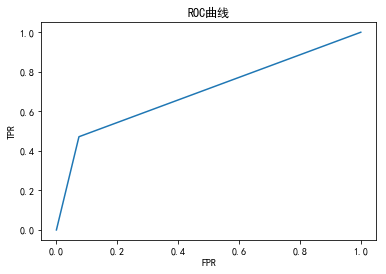

Confusion matrix, without normalization
[[22274  1781]
 [ 4808  4288]]


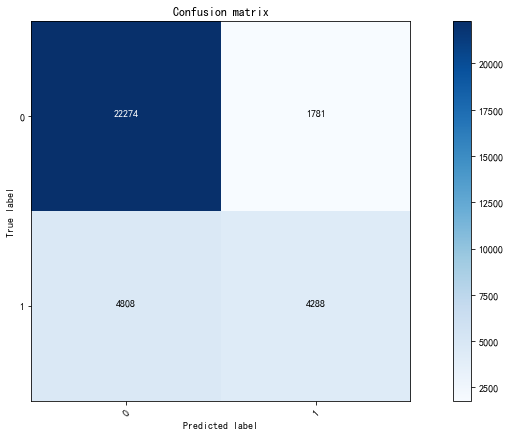

In [30]:
print('LR模型:')
evaluate(y_train, run_cv1(X_train, y_train, LR))

RF模型:
accuracy: 0.788392507013363
recall: 0.44052330694810904
F1_score: 0.5332357442278262
              precision    recall  f1-score   support

           0       0.81      0.92      0.86     24055
           1       0.68      0.44      0.53      9096

    accuracy                           0.79     33151
   macro avg       0.74      0.68      0.70     33151
weighted avg       0.78      0.79      0.77     33151

AUC: 0.6802283963549525


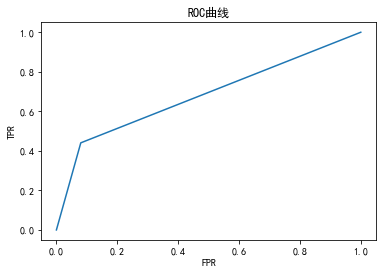

Confusion matrix, without normalization
[[22129  1926]
 [ 5089  4007]]


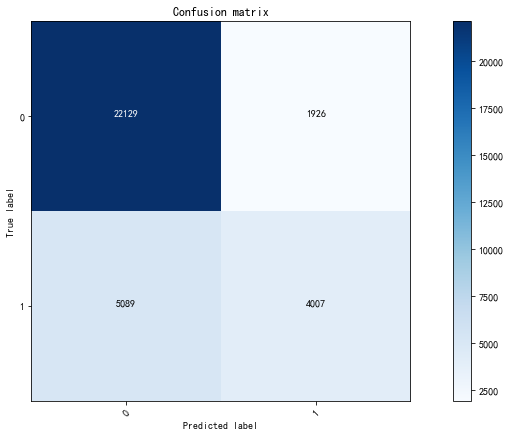

In [31]:
print('RF模型:')
evaluate(y_train, run_cv1(X_train, y_train, RF))

KNN模型:
accuracy: 0.7577448644083135
recall: 0.38511433597185574
F1_score: 0.4659174037374476
              precision    recall  f1-score   support

           0       0.79      0.90      0.84     24055
           1       0.59      0.39      0.47      9096

    accuracy                           0.76     33151
   macro avg       0.69      0.64      0.65     33151
weighted avg       0.74      0.76      0.74     33151

AUC: 0.6418816327541674


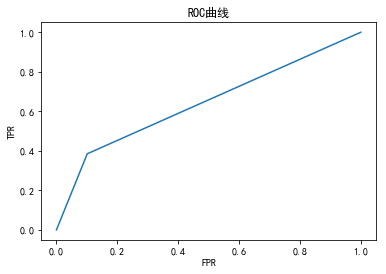

Confusion matrix, without normalization
[[21617  2438]
 [ 5593  3503]]


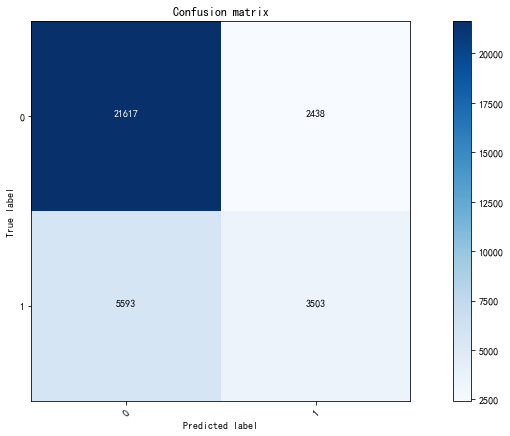

In [32]:
print('KNN模型:')
evaluate(y_train, run_cv1(X_train, y_train, KNN))

In [ ]:
# 卡死
print('SVM模型由于计算量大，出现卡死情况')
# evaluate(y, run_cv1(X, y, SVC, gamma='auto'))

SVM模型:


- 综合评价后选择LR模型作为预测模型

## 参数调节

In [33]:
from sklearn.model_selection import GridSearchCV
# 参数设置
params = {
    'C' : [0.001, 0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'sag', 'lbfgs', 'newton-cg']
}
lr = LR()
clf = GridSearchCV(lr, param_grid=params, cv=10)
clf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'solver': ['liblinear', 'sag', 'lbfgs', 'newton-cg']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [34]:
clf.best_params_

{'C': 0.1, 'solver': 'liblinear'}

LR模型:
accuracy: 0.8044704533799886
recall: 0.4758135444151275
F1_score: 0.5718060509974897
              precision    recall  f1-score   support

           0       0.82      0.93      0.87     24055
           1       0.72      0.48      0.57      9096

    accuracy                           0.80     33151
   macro avg       0.77      0.70      0.72     33151
weighted avg       0.79      0.80      0.79     33151

AUC: 0.7022800833694843


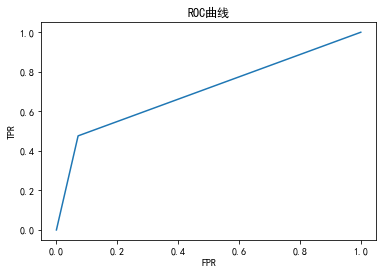

Confusion matrix, without normalization
[[22341  1714]
 [ 4768  4328]]


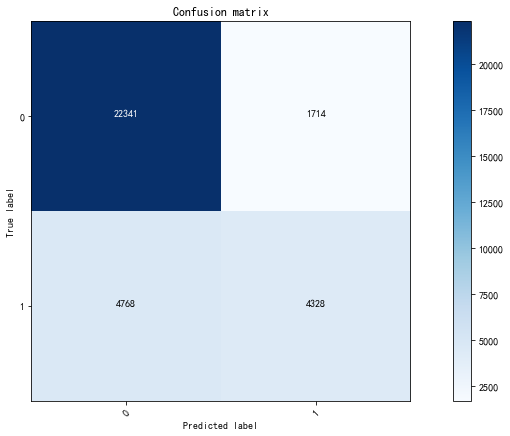

In [35]:
print('LR模型:')
evaluate(y_train, clf.predict(X_train))

- 调了参数，有少许提升

In [36]:
# 对测试集进行预测
y_test_pred = clf.predict(X_test)

In [147]:
# 提取出预测为1的玩家，也就是会继续付费玩家进行回归预测
X_test_reg = X_test[y_test_pred==1]

In [149]:
# 用线性回归进行预测
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train_reg)
y_test_reg_pred = linreg.predict(X_test_reg)

In [152]:
# 合并预测结果
y_test_pred[y_test_pred==1] = y_test_reg_pred

In [169]:
# 用y_test_reg中的充值玩家的充值金额替换掉y_test中的1值
y_test[y_test==1] = y_test_reg[y_test==1]

In [182]:
y_test = y_test.reset_index(drop=True)

In [225]:
# 计算均方根误差，评估预测结果
import math
temp = np.array([])
for i in range(len(y_test)):
    n = (y_test_pred[i] - y_test[i])**2
    temp = np.append(temp, n) 
print('均方根误差为：' ,math.sqrt(temp.sum() / len(y_test)) )

均方根误差为： 526.9508600013645


- 预测效果不太理想，均方根误差太大

## 尝试使用集成算法 XGBoost

In [251]:
from xgboost import XGBClassifier
model = GridSearchCV(
        estimator = XGBClassifier(max_bin=128),
        param_grid = {
            'n_estimators': [10, 100, 1000],
            'learning_rate': [0.01, 0.1, 1],
            'max_depth': [2, 3],
            'subsample': [1],
            'colsample_bytree': [0.8],
            'scale_pos_weight': [2.5],
            'min_child_weight': [2]
            
        },
        scoring = 'f1',
        cv = 3,
        n_jobs = 1,
        verbose = 1   
)

In [252]:
model.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed: 12.7min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_bin=128,
                                     max_delta_step=0, max_depth=3,
                                     min_child_weight=1, missing=None,
                                     n_estimators=100, n_jobs=1, nthread=None,
                                     objective='binary:logistic',
                                     random_state=0, reg_a...=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=1,
             param_grid={'colsample_bytree': [0.8],
                         'learning_rate': [0.01, 0.1, 1], 'max_depth': [2, 3],
    

In [254]:
# 使用训练好的XGBoost预测X_test
y_test_pred_xgb = model.predict(X_test)

In [255]:
# 提取出预测为1的玩家，也就是会继续付费玩家进行回归预测
X_test_reg_xgb = X_test[y_test_pred_xgb==1]

In [256]:
# 用线性回归进行预测
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train_reg)
y_test_reg_pred_xgb = linreg.predict(X_test_reg_xgb)

In [257]:
# 合并预测结果
y_test_pred_xgb[y_test_pred_xgb==1] = y_test_reg_pred_xgb

In [258]:
#计算均方根误差
temp = np.array([])
for i in range(len(y_test)):
    n = (y_test_pred_xgb[i] - y_test[i])**2
    temp = np.append(temp, n) 

print('均方根误差为：' ,math.sqrt(temp.sum() / len(y_test)) )

均方根误差为： 74.33455918473715


### 使用XGBoost后，均方根误差降到74，集成算法的威力太强了